# DA5401 Assignment 7 : Multi Class Model Selection using ROC and PRC

### Problem Statement

 We have the **UCI Landsat Satellite Data**, which is a multi-class problem, known to be non-trivial due to high dimensionality and potential class overlap. We need to perform model selection by comparing various classifier types using **ROC(Receiver Operating Characteristic) Curves and PRC(Precision-Recall Curve) Analysis** adapted for the multi-class setting(using one vs rest averaging), to determine the best-performing and worst-performing models. 

### Dataset

UCI Landsat Satellite Data is dataset with **6 primary classes**. The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood.   
The database is a (tiny) sub-area of a scene, consisting of 82 x 100 pixels. Each line of data corresponds to a 3x3 square neighbourhood of pixels completely contained within the 82x100 sub-area. Each line contains the pixel values in the four spectral bands (converted to ASCII) of each of the 9 pixels in the 3x3 neighbourhood and a number indicating the classification label of the central pixel. The number is a code for the following classes:

**Number			Class**  
1			red soil  
2			cotton crop  
3			grey soil  
4			damp grey soil  
5			soil with vegetation stubble  
6			mixture class (all types present)  
7			very damp grey soil  
	  
*Note* - There are no examples with class 6 in this dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Part A - Data Preparation and Baseline

### Load the Dataset and Train-Test Split

The Dataset is already divided into training and testing sets, so we do not need to do any train-test split.

In [2]:
df_train = pd.read_csv('sat.trn', sep=" ", header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [3]:
df_test  = pd.read_csv('sat.tst', sep=" ", header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,80,102,102,79,76,102,102,79,76,102,...,87,79,107,109,87,79,107,113,87,3
1,76,102,102,79,76,102,106,83,76,102,...,87,79,107,113,87,79,103,104,83,3
2,80,98,106,79,76,94,102,76,76,94,...,79,79,95,100,79,79,95,96,75,4
3,76,94,102,76,76,94,102,76,76,94,...,79,79,95,96,75,79,95,100,75,4
4,76,94,102,76,76,94,102,76,76,89,...,75,79,95,100,75,75,95,100,79,4


In [4]:
print (df_train.shape)
print (df_test.shape)

(4435, 37)
(2000, 37)


In [5]:
print (df_train.isnull().any(axis=1).sum())
print (df_test.isnull().any(axis=1).sum())

0
0


There are **no null values** in both the training and testing datasets.

### Divide into features and target

In [6]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

#### Class Distribution in training set

Class distribution:
36
1    1072
7    1038
3     961
2     479
5     470
4     415
Name: count, dtype: int64


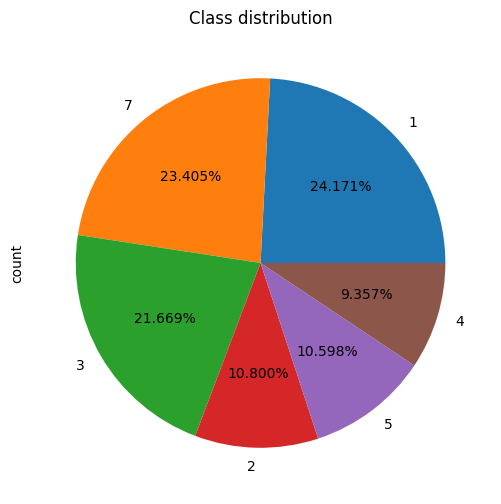

In [7]:
class_dist = y_train.value_counts()
print("Class distribution:")
print(class_dist)

plt.figure(figsize = (6,6))
class_dist.plot.pie(autopct = '%1.3f%%', shadow = False)
plt.title("Class distribution")
plt.show()

We can see that this dataset is moderately imbalanced.

### Standardization

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Training all the models

### K-Nearest Neighbors Classifier

In [9]:
from sklearn.neighbors import KNeighborsClassifier

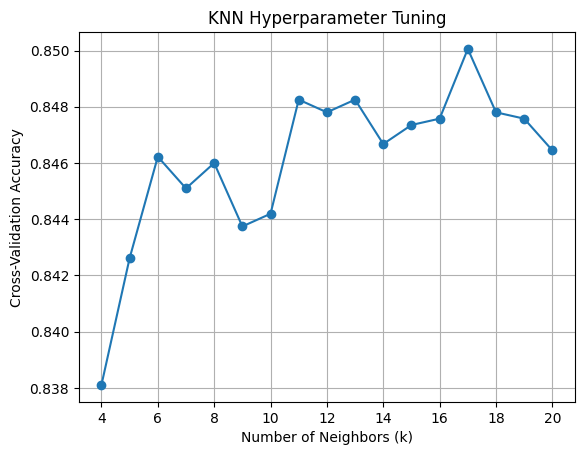

In [10]:
# Tune the hyperparameter k

k_values = range(4, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, scoring = 'accuracy')
    cv_scores.append(scores.mean())

# 5️⃣ Plot CV accuracy vs K
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Hyperparameter Tuning')
plt.grid(True)
plt.show()

In [11]:
# Pick best k
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Best k = {best_k} with CV Accuracy = {max(cv_scores):.4f}")

# Train final KNN model with best k
best_knn = KNeighborsClassifier(n_neighbors = best_k)
best_knn.fit(X_train_scaled, y_train)

Best k = 17 with CV Accuracy = 0.8501


,n_neighbors,17
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### Decision Tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
dt = DecisionTreeClassifier(criterion = 'entropy', random_state=42)

param_grid = {
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf' : [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(dt, param_grid, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Best parameters and model
print("Best Parameters:", grid.best_params_)
best_dt = grid.best_estimator_

Best Parameters: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 10}


### Dummy Classifier

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
dummy = DummyClassifier(strategy = 'prior')
dummy.fit(X_train_scaled, y_train)

,strategy,'prior'
,random_state,None
,constant,None


### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(class_weight = 'balanced', max_iter = 500, random_state = 77), param_grid, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best C:", grid.best_params_['C'])
print("Best CV Accuracy:", grid.best_score_)

Best C: 0.1
Best CV Accuracy: 0.8202931228861331


In [18]:
logreg = LogisticRegression(C = grid.best_params_['C'], class_weight = 'balanced', max_iter = 200, random_state = 77)
logreg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,77
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


### Gaussian Naive-Bayes Classifier

In [19]:
from sklearn.naive_bayes import GaussianNB

In [20]:
gnb = GaussianNB(var_smoothing=1e-9)
gnb.fit(X_train_scaled, y_train)

,priors,None
,var_smoothing,1e-09


### Support Vector Machine Classifier

In [21]:
from sklearn.svm import SVC

In [22]:
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'gamma': ['scale', 0.1, 0.01, 0.001],
}

grid = GridSearchCV(SVC(probability = True, class_weight = 'balanced', random_state = 24), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

,estimator,SVC(class_wei...ndom_state=24)
,param_grid,"{'C': [0.1, 0.5, ...], 'gamma': ['scale', 0.1, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.5


In [23]:
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Evaluate best model
best_svc = grid.best_estimator_

Best Parameters: {'C': 0.5, 'gamma': 0.1}
Best CV Accuracy: 0.8351726455751137


## Baseline Evaluation

In [24]:
models = {
    "Dummy": dummy,
    "KNN": best_knn,
    "Decision Tree": best_dt,
    "Logistic Regression": logreg,
    "Gaussian NB": gnb,
    "SVC": best_svc
}


results = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='weighted')
    results.append([name, acc, f1])

# Create results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1"])
print(results_df.sort_values(by="Weighted F1", ascending=False).to_string(index=False))

              Model  Accuracy  Weighted F1
                SVC    0.8965     0.898201
                KNN    0.8910     0.889484
      Decision Tree    0.8460     0.845707
Logistic Regression    0.8400     0.844755
        Gaussian NB    0.7965     0.803581
              Dummy    0.2305     0.086356


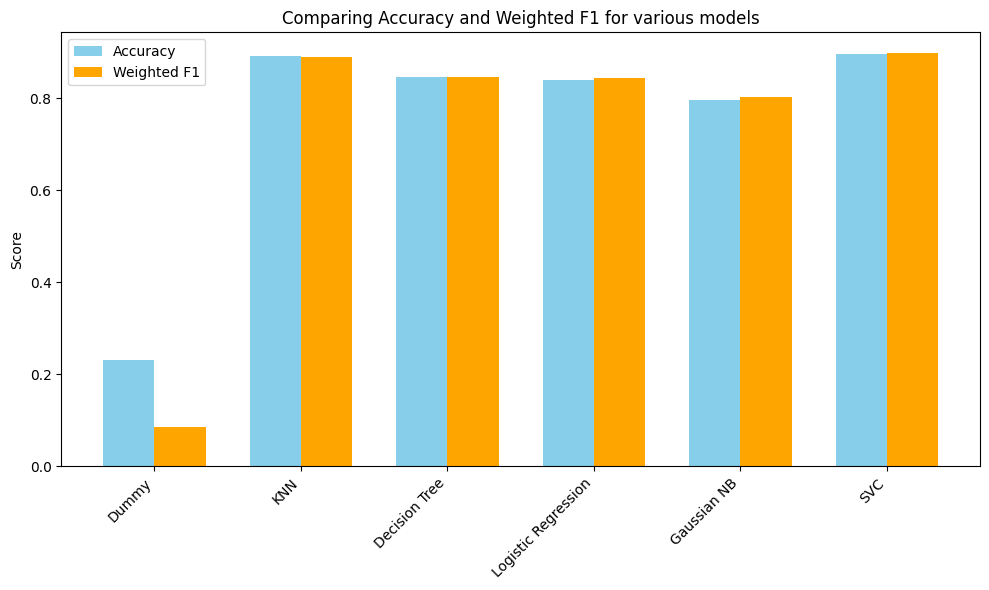

In [25]:
accuracy = results_df["Accuracy"]
f1 = results_df["Weighted F1"]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, f1, width, label='Weighted F1', color='orange')

plt.xticks(x, results_df["Model"], rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Comparing Accuracy and Weighted F1 for various models')
plt.legend()
plt.tight_layout()
plt.show()

### Observations

- Dummy Classifier is the worst-performing Classifier(obviously).
- Of all the actual models, Gaussian Naive Bayes Classifier is the worst-performing one ( since it assumes that all features are independent, which is almost never the case with real data)
- SVC and KNN have very high Accuracy and F1-score
- Decision Tree and Logistic Regression models perform moderately on the data

## Part B : ROC Analysis for Model Selection

### Multi-Class ROC Calculation - One vs Rest Approach

ROC curves are typically used in binary classification, where the TPR and FPR can be defined unambiguously. In the case of multiclass classification, a notion of TPR or FPR is obtained only after binarizing the output. This can be done in 2 different ways:

- The One-vs-Rest scheme compares each class against all the others (assumed as one);
- The One-vs-One scheme compares every unique pairwise combination of classes.

The **One-vs-the-Rest (OvR) multiclass strategy**, also known as one-vs-all, consists in computing a ROC curve per each of the n classes. In each step, a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk. This converts one multi-class problem into K binary classification problems.

Then we can calculate , *for each class*, 
- True Positive Rate = TP/(TP+FN)
- False Positive Rate = FP/(FP+TN)
- Plot the ROC curve at various thresholds
- Calculate AUC = Area under the ROC curve

Macro-Average AUC = Mean of AUCs across all classes  
Weighted-Average AUC = Weighted Mean of AUCs across all classed

We use a *LabelBinarizer* to binarize the target by one-hot-encoding in a OvR fashion. This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).

## Plotting ROC curve -- Macro-Average ROC

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [27]:
y_score_models = {}
for name, model in models.items():
    y_score_models[name] = model.predict_proba(X_test_scaled)

In [28]:
classes = [1, 2, 3, 4, 5, 7]
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = 6

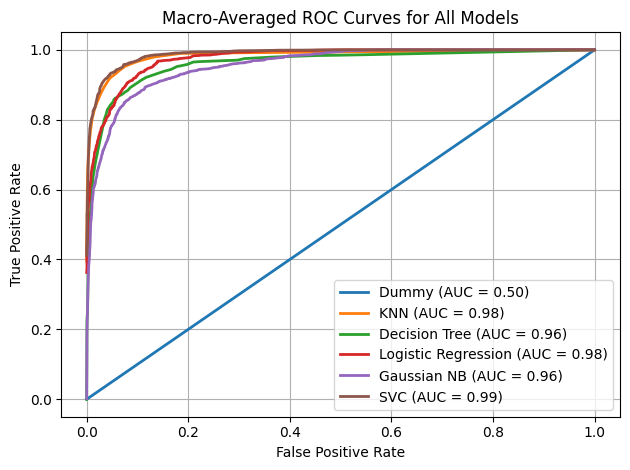

In [29]:
macro_auc_scores = {}  # to store AUC for each model

for name, y_score in y_score_models.items():
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)
    macro_auc_scores[name] = macro_auc
    
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {macro_auc:.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
print("\nMacro-Averaged AUC Scores")
for name, auc_val in sorted(macro_auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20s}: {auc_val:.4f}")


Macro-Averaged AUC Scores
SVC                 : 0.9881
KNN                 : 0.9837
Logistic Regression : 0.9751
Decision Tree       : 0.9612
Gaussian NB         : 0.9553
Dummy               : 0.5000


## ROC Interpretation

#### Model with Highest Macro-Averaged AUC

- The model with the *highest Macro-Averaged AUC is Support Vector Machine Classifier*.   
- This indicates that SVC model has the highest overall classifying ability across all 6 classes.  
- AUC value being very close to 1 indicates that this model achieves near-perfect ranking of positive vs negative instances in one vs rest comparison.

#### Model with AUC <= 0.5

- The model with the *least Macro-Averaged AUC is the Dummy Classifier*.   
- AUC value of Dummy Classifier = 0.5

### Conceptual Meaning of AUC <= 0.5

- An AUC of 0.5 indicates random performance — the model is no better than flipping a coin at ranking positive vs. negative samples.
- If AUC were < 0.5, it would mean the model is systematically ranking positive examples lower than negative ones, i.e. performing worse than random.

### Why a Model might show AUC <= 0.5

1. *Random or trivial model (like Dummy)*: Predicts class probabilities purely based on class frequency or prior probabilities — not the input features.
2. *Misaligned probabilities or inverted scores*: Sometimes AUC < 0.5 occurs if the decision scores are inverted (e.g., predicting low scores for true positives).
3. Severe imbalance or *data corruption*
4. If features have no predictive power or the *model is poorly trained*.

## Part C - Precision-Recall Curve(PRC) Analysis

### PRC Calculation

Precision = TP/(TP + FP)  
Recall = TP/(TP + FN) -- Also known as Sensitivity or True Positive Rate  

The PR curve is created by changing the decision threshold of your model and checking how the precision and recall change at each step. The threshold is the cutoff point where you decide:  
If the probability is above the threshold you predict positive.  
If it's below you predict negative.

### Why PRC is more suitable than ROC for imbalanced classes

- The ROC curve plots True Positive Rate (Recall) vs False Positive Rate (FPR). However, when the dataset is highly imbalanced, the number of negatives far exceeds positives.  
This means the FPR can appear very small even if the model misclassifies many positives as negatives, making the ROC curve overly optimistic.

- The Precision-Recall Curve (PRC) focuses only on the positive class — plotting Precision vs Recall.  
It reflects how well the model identifies the minority class without being “distracted” by the large number of true negatives.

- PRC highlights performance where it matters most — detecting the minority class correctly with few false positives. 
In imbalanced settings, high Precision and Recall together are more meaningful than a low FPR.

Even if the imbalance is moderate, PRC provides a more informative view of the classification power for rare classes.

### Plotting PRC curve -- Macro-Averaged PRC

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

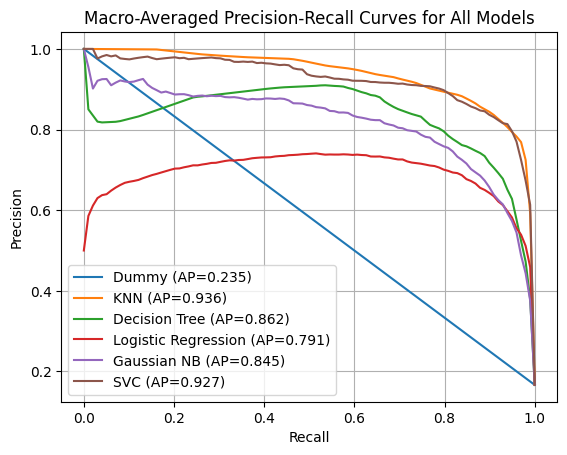

In [32]:
ap = {}
for name, model in models.items():
    if hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test_scaled)
    else:
        y_score = model.predict_proba(X_test_scaled)

    precision_curves = []
    recall_curves = []

    for i in range(6):
        precision_i, recall_i, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        precision_curves.append(precision_i)
        recall_curves.append(recall_i)

        ap_per_class = []
        ap_per_class.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))

    ap[name] = np.mean(ap_per_class)              
    
    recall_points = np.linspace(0, 1, 100)
    precision_interp = []
    
    for i in range(len(classes)):
        precision_interp.append(np.interp(recall_points, recall_curves[i][::-1], precision_curves[i][::-1]))
    
    precision_avg = np.mean(precision_interp, axis=0)
    plt.plot(recall_points, precision_avg, label=f"{name} (AP={ap[name]:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision-Recall Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
ap_df = pd.DataFrame(list(ap.items()), columns=["Model", "Macro Avg AP"]).sort_values(by="Macro Avg AP", ascending=False)
print("\nMacro-Average Precision (AP) Scores, Sorted")
display(ap_df.round(4))


Macro-Average Precision (AP) Scores, Sorted


,Model,Macro Avg AP
1,KNN,0.9357
5,SVC,0.9266
2,Decision Tree,0.8620
4,Gaussian NB,0.8454
3,Logistic Regression,0.7907
0,Dummy,0.2350


### PRC Interpretation

#### Model with highest AP

The model with the highest Macro-Average AP is the KNN model with an Avg Precision of 0.936.  
This indicates that it maintains high precision even as recall increases across classes and it achieves good balance between identifying true positives and avoiding false positives for all 6 classes.  
Therefore, KNN's predictions are more reliable than the other 5 models.

#### Worst-Performing Model

- The Dummy Classifier has the lowest AP (0.2350), which is close to random guessing.
- Its Precision–Recall Curve (PRC) shows a sharp drop in precision as recall increases.

**Why the Curve Drops Sharply**  

- At low recall, the model predicts only a few positive instances — possibly by chance — giving a small region of slightly higher precision.
- As recall increases, the model starts predicting more positives to cover more actual positive samples, but since it lacks discriminative power, it introduces many false positives.
- This causes precision to fall steeply as recall grows.

- A good model identifies true positives confidently and early, means it has high precision across recall range. So, its PRC curve will be flatter and higher whereas a poor model (like Dummy) has no meaningful separation between classes, so PRC curve collapses quickly.

## --Brownie Points Tasks--

### Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

n_classes = len(le.classes_)

In [36]:
rf = RandomForestClassifier(random_state=68)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

grid_rf = GridSearchCV(rf, param_grid_rf,cv = 5, n_jobs = -1, scoring = 'f1_weighted')
grid_rf.fit(X_train_scaled, y_train_enc)

print("Best RandomForest Parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

Best RandomForest Parameters: {'max_depth': None, 'n_estimators': 200}


In [37]:
best_rf.fit(X_train_scaled, y_train_enc)
y_pred_rf = best_rf.predict(X_test_scaled)
y_prob_rf = best_rf.predict_proba(X_test_scaled)

### XGBoost Classifier

In [38]:
from xgboost import XGBClassifier

In [39]:
xgb = XGBClassifier(num_class =6, objective = 'multi:softprob', eval_metric = 'mlogloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb,cv = 5, n_jobs = -1, scoring = 'f1_weighted')
grid_xgb.fit(X_train_scaled, y_train_enc)

print("Best XGBoost Parameters:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_


Best XGBoost Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}


In [40]:
best_xgb.fit(X_train_scaled, y_train_enc)
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_prob_xgb = best_xgb.predict_proba(X_test_scaled)

### Bad Model with AUC <= 0.5 -- Intentionally Flipped labels model

In [41]:
import warnings
from sklearn.exceptions import ConvergenceWarning

rng = np.random.default_rng(seed=42)
y_train_shuffled = rng.permutation(y_train_enc)

flipped_model = LogisticRegression(max_iter = 100, random_state = 1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    flipped_model.fit(X_train, y_train_shuffled)
    
y_pred_bad = flipped_model.predict(X_test_scaled)
y_prob_bad = flipped_model.predict_proba(X_test_scaled)

In [42]:
def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    
    y_true_onehot = np.eye(len(le.classes_))[y_true]
    prc_ap = average_precision_score(y_true_onehot, y_prob, average='macro')

    return [name, acc, f1, roc_auc, prc_ap]
    
    
results = []
results.append(evaluate_model("Random Forest", y_test_enc, y_pred_rf, y_prob_rf))
results.append(evaluate_model("XGBoost", y_test_enc, y_pred_xgb, y_prob_xgb))
results.append(evaluate_model("Bad Model", y_test_enc, y_pred_bad, y_prob_bad))

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1", "Macro-AUC", "Macro-AP"])
print("\nModel Performance Summary:\n")
print(df_results.to_string(index=False, justify="center", col_space=12, float_format="%.4f"))


Model Performance Summary:

    Model       Accuracy    Weighted F1   Macro-AUC    Macro-AP  
Random Forest    0.9130       0.9112       0.9901       0.9518   
      XGBoost    0.9070       0.9055       0.9896       0.9498   
    Bad Model    0.1250       0.1319       0.4991       0.2050   


## Part D - Final Recommendation

### Synthesis

#### Model Rankings

| Model                   | Accuracy | Weighted F1 |  Macro AUC |  Macro AP  |
| :---------------------- | :------: | :---------: | :--------: | :--------: |
| **Random Forest**       |  0.9130  |    0.9112   | **0.9901** | **0.9518** |
| **XGBoost**             |  0.9070  |    0.9055   |   0.9896   |   0.9498   |
| **SVC**                 |  0.8965  |    0.8982   |   0.9881   |   0.9266   |
| **KNN**                 |  0.8910  |    0.8895   |   0.9837   |   0.9357   |
| **Decision Tree**       |  0.8460  |    0.8457   |   0.9612   |   0.8620   |
| **Gaussian NB**         |  0.7965  |    0.8036   |   0.9553   |   0.8454   |
| **Logistic Regression** |  0.8400  |    0.8448   |   0.9751   |   0.7907   |
| **Dummy**               |  0.2305  |    0.0864   |   0.5000   |   0.2350   |
| **Flipped Model**       |  0.1250  |    0.1319   |   0.4991   |   0.2050   |


| **Metric**          | **Rank 1**    | **Rank 2** | **Rank 3** | **Rank 4** | **Rank 5**          | **Rank 6**          | **Rank 7**          | **Rank 8**    | **Rank 9**    |
| :------------------ | :------------ | :--------- | :--------- | :--------- | :------------------ | :------------------ | :------------------ | :------------ | :------------ |
| **Weighted F1**     | Random Forest | XGBoost    | SVC        | KNN        | Decision Tree       | Logistic Regression | Gaussian NB         | Flipped Model | Dummy         |
| **ROC-AUC (Macro)** | Random Forest | XGBoost    | SVC        | KNN        | Logistic Regression | Decision Tree       | Gaussian NB         | Dummy         | Flipped Model |
| **PRC-AP (Macro)**  | Random Forest | XGBoost    | KNN        | SVC        | Decision Tree       | Gaussian NB         | Logistic Regression | Dummy         | Flipped Model |


#### Rankings Alignment

- The rankings across Accuracy, AUC, and Average Precision are largely consistent.
- Random Forest and XGBoost clearly dominate all metrics, showing high accuracy, excellent separability (AUC ≈ 0.99), and strong precision–recall balance (AP ≈ 0.95).
- SVC and KNN form the next tier. Both achieve strong AUCs (0.98–0.99) but slightly lower PRC–APs, suggesting that although they distinguish classes well, they lose precision when recall increases.
- Decision Tree performs moderately, benefiting from interpretability but suffering from overfitting and weaker probability calibration.
- Gaussian NB and Logistic Regression trail behind due to simplifying independence or linearity assumptions that do not capture complex class boundaries.
- The Dummy classifier predictably ranks last, serving only as a baseline with no discriminative capability.

#### Trade-offs 

While ROC-AUC remains high for almost all non-baseline models, PRC-AP better exposes precision–recall trade-offs under class imbalance. Thus, a model can have a strong ROC-AUC yet perform worse in PRC-AP if it produces many false positives at high recall. In this dataset, however, the ensemble models maintain high performance under both metrics, indicating robust threshold behavior.

### Recommendation

### Best Overall Model - Random Forest Classifier

- Achieves best performance across all three metrics.
- Offers excellent precision–recall trade-off, indicating consistent reliability across thresholds.
- Provides better generalization and interpretability than most of the other models
- XGBoost is a very close second.